In [2]:
import pandas as pd

# 讀取CSV文件
df = pd.read_csv("C:\\Users\\Modern 14\\Desktop\\codementorTest\\person\\fn01_table_person__merged_output.csv")
# df = pd.read_csv(r"C:\pythonpractice\thesis\link_0ibrahimyilmaz.csv")
# df.fillna(0, inplace=True)

# 篩選出評論數大於等於29的鏈接################
link_counts = df['link'].value_counts()
df = df[df['link'].isin(link_counts[link_counts >= 20].index)]
############################################


# 將日期格式轉換為datetime
df['time'] = pd.to_datetime(df['time'])
############################################
# 將日期修改為該月的第一天
df['time'] = df['time'].dt.to_period('M').dt.to_timestamp()
############################################

############################################
# 找到所有缺失的鏈接
zero_review_links = df.groupby('link')['p_job'].apply(lambda x: x.isnull().all() or x.nunique() == 1)
zero_review_links.sort_index(inplace=True)

# 剔除所有評論都為零的鏈接
df = df[~df['link'].isin(zero_review_links[zero_review_links].index)]
df=(df.set_index('time')
   .groupby('link', as_index=False)
   .apply(lambda d: d.reindex(pd.date_range(d.index.min(), d.index.max(), freq='MS')))
   .interpolate(method='linear')
   .ffill()
   .reset_index(level=0, drop=True)
)

df.reset_index(inplace=True)
df.rename(columns = {'index':'time'}, inplace = True) 


<h1 align = 'center'>計算基數與成長差距 </h1>

In [3]:
from scipy.stats import gmean


# Step 1: 計算每個連結的第一期
first_period_p_job = df[df.groupby('link')['time'].transform('min') == df['time']][['link', 'p_job']]
first_period_p_job.rename(columns={'p_job': 'first_period_p_job'}, inplace=True)

# Step 2: 計算每個連結的 p_job 最後一期與第一期的差距

p_job_diff = df.groupby('link')['p_job'].apply(lambda x: (x.iloc[-1] - x.iloc[0])).reset_index()
p_job_diff.columns = ['link', 'p_job_diff']
result_df = pd.merge(first_period_p_job, p_job_diff, on='link')


# # Step 3: 計算每個連結的 p_job 成長率
# p_job_growthRate = df.groupby('link')['p_job'].apply(lambda x: (x.iloc[-1] - x.iloc[0])/x.iloc[0]).reset_index()
# p_job_growthRate.columns = ['link', 'p_job_growthRate']
# result_df = pd.merge(first_period_p_job, p_job_growthRate, on='link')


## Step 6: 篩選出 p_job_diff 大於等於0的連結
result_df=result_df[result_df['p_job_diff'] >=1]
result_df


,link,first_period_p_job,p_job_diff
1,/@0xtimc,12.0,17.0
2,/@11995shubham,109.0,149.0
3,/@_lutfor,227.0,18.0
4,/@a.k,426.0,442.0
5,/@aakshisharma893,4.0,18.0
...,...,...,...
1733,/@zanethomas,23.0,22.0
1736,/@zbigniewczapran,4.0,3.0
1742,/@ziad-saab,123.0,15.0
1744,/@zoltnorbn,23.0,28.0


In [4]:
# result_df[result_df['link'] == '/@a.k']   

result_df.sort_values(by='p_job_diff', ascending=False, inplace=True)
result_df

,link,first_period_p_job,p_job_diff
477,/@e4c5,3154.0,1892.0
862,/@kalaiselvid,52.0,1729.0
1303,/@rajharajesuwari,1581.0,1676.0
351,/@coffeetocode,1377.0,1582.0
1524,/@stefangeorg,2398.0,1401.0
...,...,...,...
1415,/@sandeepranjan2007,24.0,1.0
1420,/@santoshpatel,1.0,1.0
251,/@bobbybouwmann,10.0,1.0
235,/@bhlvoong,3.0,1.0


<h1 align ='center'>畫出成長數量散布圖</h1>

c:\Users\Modern 14\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


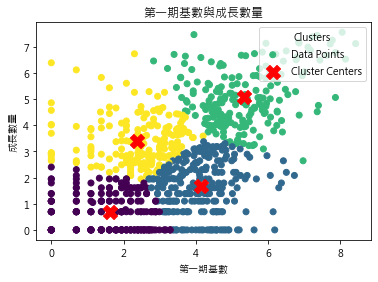

In [188]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np

result_df['p_job_diff'] = np.where(result_df['p_job_diff'] <= 0, np.nan, result_df['p_job_diff'])
# 對 'p_job_first' 列取對數，NaN 將被保留為 NaN
result_df['log_p_job_diff'] = np.log(result_df['p_job_diff'])


# 對 'p_job_first' 列取對數
result_df['log_p_job_first'] = np.log(result_df['first_period_p_job'])


plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False

# selected_features = ['p_star', 'p_review', 'p_money', 'p_job', 'p_message_label_count', 'p_message_First_15', 'p_message_Featured_Mentor', 'p_message_Facebook', 'review_growth_per_link', 'percentile_rank']
selected_features = ['log_p_job_first','log_p_job_diff']

# K-means叢集分析
kmeans = KMeans(n_clusters=4, random_state=42)
result_df['cluster'] = kmeans.fit_predict(result_df[selected_features])

# 繪製散點圖
centers = kmeans.cluster_centers_
plt.scatter(result_df['log_p_job_first'], result_df['log_p_job_diff'], c=result_df['cluster'], cmap='viridis', label='Data Points')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='X', s=200, label='Cluster Centers')

plt.xlabel('第一期基數')
plt.ylabel('成長數量')

plt.title('第一期基數與成長數量')
# plt.xlabel('percentile_rank')
# plt.ylabel('review_growth_per_link (Standardized)')
plt.legend(title='Clusters', loc='upper right')
plt.show()



c:\Users\Modern 14\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


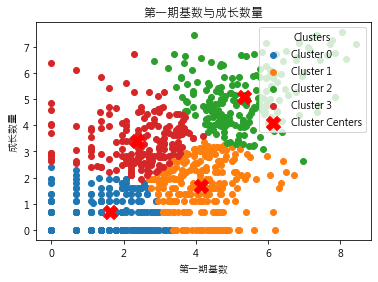

In [189]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np

result_df['p_job_diff'] = np.where(result_df['p_job_diff'] <= 0, np.nan, result_df['p_job_diff'])
# 对 'p_job_first' 列取对数，NaN 将被保留为 NaN
result_df['log_p_job_diff'] = np.log(result_df['p_job_diff'])

# 对 'p_job_first' 列取对数
result_df['log_p_job_first'] = np.log(result_df['first_period_p_job'])

plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False

# 选取特征
selected_features = ['log_p_job_first','log_p_job_diff']

# K-means聚类分析
kmeans = KMeans(n_clusters=4, random_state=42)
result_df['cluster'] = kmeans.fit_predict(result_df[selected_features])

# 绘制散点图
centers = kmeans.cluster_centers_
for cluster_label in range(4):
    cluster_data = result_df[result_df['cluster'] == cluster_label]
    plt.scatter(cluster_data['log_p_job_first'], cluster_data['log_p_job_diff'], label=f'Cluster {cluster_label}')

plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='X', s=200, label='Cluster Centers')

plt.xlabel('第一期基数')
plt.ylabel('成长数量')

plt.title('第一期基数与成长数量')
plt.legend(title='Clusters', loc='upper right')
plt.show()


<h1 align="center">標準化後結果</h1>

c:\Users\Modern 14\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


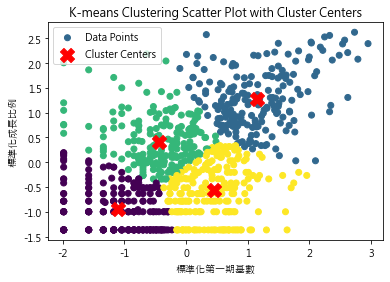

In [6]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# 選擇要標準化的特徵
selected_features = ['log_p_job_first', 'log_p_job_diff']

# 創建 StandardScaler 對象
scaler = StandardScaler()

# 對選擇的特徵進行標準化
scaled_features = scaler.fit_transform(result_df[selected_features])

# K-means叢集分析
kmeans = KMeans(n_clusters=4, random_state=42)
result_df['cluster'] = kmeans.fit_predict(scaled_features)

# 繪製散點圖
plt.scatter(scaled_features[:, 0], scaled_features[:, 1], c=result_df['cluster'], cmap='viridis', label='Data Points')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='X', s=200, label='Cluster Centers')

plt.title('K-means Clustering Scatter Plot with Cluster Centers')
plt.xlabel('標準化第一期基數')
plt.ylabel('標準化成長比例')
plt.legend()
plt.show()


<h1 align="center">-----------------分隔線--------------------</h1>

In [7]:
import pandas as pd

# 讀取CSV文件
# df = pd.read_csv("C:\\Users\\Modern 14\\Desktop\\codementorTest\\person\\fn01_table_person__merged_output.csv")
df = pd.read_csv(r"C:\Users\Modern 14\Desktop\codementorAll\test\merged_output.csv")

# 篩選出評論數大於等於20的鏈接
link_counts = df['link'].value_counts()
df = df[df['link'].isin(link_counts[link_counts >= 20].index)]

# 將日期格式轉換為datetime
df['time'] = pd.to_datetime(df['time'])

# 將日期修改為該月的第一天
df['time'] = df['time'].dt.to_period('M').dt.to_timestamp()

# 找到所有缺失的鏈接
zero_review_links = df.groupby('link')['p_job'].apply(lambda x: x.isnull().all() or x.nunique() == 1)
zero_review_links.sort_index(inplace=True)

# 剔除所有評論都為零的鏈接
df = df[~df['link'].isin(zero_review_links[zero_review_links].index)]

# 重新索引並填充缺失值
df = (df.set_index('time')
      .groupby('link', as_index=False)
      .apply(lambda d: d.reindex(pd.date_range(d.index.min(), d.index.max(), freq='MS')))
      .interpolate(method='linear')
      .ffill()
      .reset_index(level=0, drop=True)
)

# 重設索引
df.reset_index(inplace=True)
df.rename(columns={'index': 'time'}, inplace=True)

# 創建一個字典來儲存每個數值型變數的第一期值和最後一期值
diff_dict = {}

## 獲取 p_job 的第一期和最後一期的值
first_value = df.groupby('link')['p_job'].first()
last_value = df.groupby('link')['p_job'].last()
diff_dict['p_job' + '_first'] = first_value
diff_dict['p_job' + '_diff'] = (last_value - first_value)
############################################

## 獲取 p_star, p_review, p_money 的 max-min 差值
growth_columns = ['p_star', 'p_review', 'p_money', 'em_count', 'ex_count', 'pro_count', 're_count', 'a_headline_count', 'headline_readability', 'a_about_count', 'about_readability']

for col in growth_columns:
    max_value = df.groupby('link')[col].max()
    min_value = df.groupby('link')[col].min()
    avg_value = df.groupby('link')[col].mean()
    first_value = df.groupby('link')[col].first()
    diff_dict[col + '_diff'] = (max_value - min_value)
    diff_dict[col + '_avg'] = avg_value
    diff_dict[col + '_first'] = first_value
############################################

## 獲取其他數值型變數的最大值   
numeric_columns = df.select_dtypes(include='number').columns.tolist()
remove_columns = ['p_job','p_star', 'p_review', 'p_money', 'em_count', 'ex_count', 'pro_count', 're_count', 'a_headline_count', 'headline_readability', 'a_about_count', 'about_readability']

for col in remove_columns:
    numeric_columns.remove(col)
for col in numeric_columns:
    max_value = df.groupby('link')[col].max()
    diff_dict[col] = (max_value)
############################################
    

## 計算每個變數的第一期和最後一期的差距、增長率
# for col in numeric_columns:
#     first_value = df.groupby('link')[col].first()
#     last_value = df.groupby('link')[col].last()
#     diff_dict[col + '_diff'] = (last_value - first_value)
#     # diff_dict[col + '_first'] = first_value
#     # diff_dict[col + '_growth'] = (last_value - first_value) / first_value
############################################
    


# 將字典轉換為DataFrame
diff_df = pd.DataFrame(diff_dict).reset_index()

# 重命名列名
diff_df.rename(columns={'index': 'link'}, inplace=True)

# 篩選出 p_job_diff 大於等於0的連結
diff_df = diff_df[diff_df['p_job_diff'] >= 1]


In [8]:
from scipy.stats import gmean
import numpy as np


# 計算每一期p_job較上一期的成長率
df['p_job_growth_rate'] = df.groupby('link')['p_job'].pct_change()
df['p_job_growth_rate'] += 0.0001
# 將第一期的成長率設置為0
df.loc[df.groupby('link').head(1).index, 'p_job_growth_rate'] = 0

############################################
# 計算成長率的幾何平均數
# geo_mean_growth_rate = df.groupby('link')['p_job_growth_rate'].apply(lambda x: gmean(1 + x) - 1)
# # 將幾何平均數加入到DataFrame中作為新欄位
# diff_df['geo_mean_growth_rate'] = diff_df['link'].map(geo_mean_growth_rate)
# ############################################

# ############################################
# # 計算成長率的算術平均數
# paasche_arithmetic_mean = df.groupby('link')['p_job_growth_rate'].mean()
# # 將算術平均數加入到DataFrame中作為新欄位
# diff_df['arithmetic_mean_growth_rate'] = diff_df['link'].map(paasche_arithmetic_mean)
############################################
diff_df[['log_p_job_first', 'log_p_job_diff']] = np.log(diff_df[['p_job_first', 'p_job_diff']])


# ##建立embodied_df 
# embodied_column = ['link', 'p_message_label_count', 'a_headline_count_diff', 'headline_readability_diff', 'a_about_count_diff','about_readability_diff','language_eng','language_hindi','c']
# embodied_df = diff_df[embodied_column].copy()
# ############################################

# ##建立objectified_df
# objectified_column = ['link', 'p_star_diff', 'p_review_diff', 'p_money_diff', 'em_count_diff', 'ex_count_diff', 'pro_count_diff', 're_count_diff']
# objectified_df = diff_df[objectified_column].copy()
# ############################################

# ##建立institutionalized_df
# institutionalized_column = ['link','p_message_First_15' ,'p_message_Featured_Mentor', 'p_message_Facebook','social_link_count','stackoverflow_label','github_label','twitter_label','linkedin_label','p_job_diff']
# institutionalized_df = diff_df[institutionalized_column].copy()



check area

c:\Users\Modern 14\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


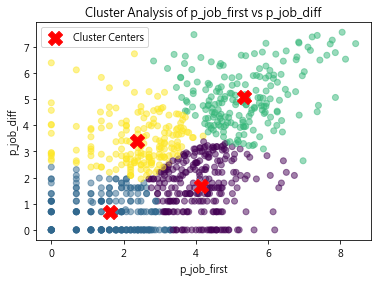

In [9]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt




# 提取需要用於聚類的特徵
X = diff_df[['log_p_job_first', 'log_p_job_diff']]

# 創建 K-means 聚類器
kmeans = KMeans(n_clusters=4, random_state=42)

# 進行聚類
diff_df['cluster'] = kmeans.fit_predict(X)

# 繪製聚類結果的散點圖
plt.scatter(diff_df['log_p_job_first'], diff_df['log_p_job_diff'], c=diff_df['cluster'], cmap='viridis', alpha=0.5)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='X', s=200, label='Cluster Centers')
plt.title('Cluster Analysis of p_job_first vs p_job_diff')
plt.xlabel('p_job_first')
plt.ylabel('p_job_diff')
plt.legend()
plt.show()


In [201]:
# new_df = diff_df[['link', 'p_job_diff']].copy()
# new_df.to_csv('C:\\Users\\Modern 14\\Desktop\\codementorAll\\test\\p_job_diff.csv', index=False)

建立3種不同的 social capital dataframe

In [10]:
##建立embodied_df 
embodied_column = ['link', 'p_message_label_count', 'a_headline_count_diff', 'headline_readability_diff', 'a_about_count_diff','about_readability_diff','language_eng','language_hindi','c','cluster']
diff_columns = [col for col in embodied_column if col.endswith('_diff')]
for col_diff in diff_columns:
    col_first = col_diff.replace('_diff', '_first')
    embodied_column.append(col_first)
    # col_avg = col_diff.replace('_diff', '_avg')
    # embodied_column.append(col_avg)
    embodied_column = [col for col in embodied_column if not col.endswith('_diff')]
embodied_df = diff_df[embodied_column].copy()
embodied_df = embodied_df.reindex(sorted(embodied_df.columns), axis=1)
############################################

##建立objectified_df
objectified_column = ['link', 'p_star_diff', 'p_review_diff', 'p_money_diff', 'em_count_diff', 'ex_count_diff', 'pro_count_diff', 're_count_diff','cluster']
diff_columns = [col for col in objectified_column if col.endswith('_diff')]
for col_diff in diff_columns:
    col_first = col_diff.replace('_diff', '_first')
    objectified_column.append(col_first)
    objectified_column = [col for col in objectified_column if not col.endswith('_diff')]
    # col_avg = col_diff.replace('_diff', '_avg')
    # objectified_column.append(col_avg)
objectified_df = diff_df[objectified_column].copy()

objectified_df = objectified_df.reindex(sorted(objectified_df.columns), axis=1)
############################################

##建立merged_df
institutionalized_column = ['link','p_message_First_15' ,'p_message_Featured_Mentor', 'p_message_Facebook','social_link_count','stackoverflow_label','github_label','twitter_label','linkedin_label','p_job_diff','cluster']
# diff_columns = [col for col in institutionalized_column if col.endswith('_diff')]
# for col_diff in diff_columns:
#     col_first = col_diff.replace('_diff', '_first')
#     institutionalized_column.append(col_first)
#     col_avg = col_diff.replace('_diff', '_avg')
#     institutionalized_column.append(col_avg)
institutionalized_df = diff_df[institutionalized_column].copy()


In [11]:
# diff_df.sort_values(by='log_p_job_diff', ascending=False, inplace=True)
# diff_df
# diff_df.to_csv(r"C:\Users\Modern 14\Desktop\codementorAll\test\diff_df.csv", index=False)

(Xt-X1)/X1群集分析

In [12]:
# import matplotlib.pyplot as plt
# from sklearn.cluster import KMeans

# # 選擇要使用的特徵
# selected_features = ['log_p_job_first', 'log_p_job_growth']

# # K-means叢集分析
# kmeans = KMeans(n_clusters=4, random_state=42)
# diff_df['cluster'] = kmeans.fit_predict(diff_df[selected_features])

# # 繪製散點圖
# plt.scatter(diff_df['log_p_job_first'], diff_df['log_p_job_growth'], c=diff_df['cluster'], cmap='viridis', label='Data Points')
# plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='X', s=200, label='Cluster Centers')

# plt.title('成長率與第一期基數的K-means叢集分析')
# plt.xlabel('第一期基數')
# plt.ylabel('成長率')
# plt.legend()
# plt.show()


In [13]:
# diff_df[diff_df['link'] == '/@a.k']   
# temp = diff_df.sort_values(by='p_job_growth', ascending=True)
# temp

成長率幾何平均 群集分析

In [14]:
# import matplotlib.pyplot as plt
# from sklearn.cluster import KMeans

# plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']
# plt.rcParams['axes.unicode_minus'] = False

# # 選擇要使用的特徵
# selected_features = ['log_p_job_first', 'log_geo_mean_growth_rate']


# # K-means叢集分析
# kmeans = KMeans(n_clusters=4, random_state=42)
# diff_df['cluster_geo'] = kmeans.fit_predict(diff_df[selected_features])

# # 繪製散點圖
# centers = kmeans.cluster_centers_
# plt.scatter(diff_df['log_p_job_first'], diff_df['log_geo_mean_growth_rate'], c=diff_df['cluster_geo'], cmap='viridis', label='Data Points')
# plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='X', s=200, label='Cluster Centers')

# plt.xlabel('第一期基數')
# plt.ylabel('幾何平均成長數量')

# plt.title('K-means Clustering Scatter Plot with Cluster Centers')
# plt.legend()
# plt.show()

標準化

In [15]:
# import matplotlib.pyplot as plt
# from sklearn.cluster import KMeans
# from sklearn.preprocessing import StandardScaler


# plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']
# plt.rcParams['axes.unicode_minus'] = False

# # 選擇要使用的特徵
# selected_features = ['log_p_job_first', 'log_geo_mean_growth_rate']

# # 創建 StandardScaler 對象
# scaler = StandardScaler()

# # 對選擇的特徵進行標準化
# scaled_features = scaler.fit_transform(diff_df[selected_features])

# # K-means叢集分析
# kmeans = KMeans(n_clusters=4, random_state=42)
# diff_df['cluster_geo'] = kmeans.fit_predict(scaled_features)

# # 繪製散點圖
# centers = kmeans.cluster_centers_
# plt.scatter(scaled_features[:, 0], scaled_features[:, 1], c=diff_df['cluster_geo'], cmap='viridis', label='Data Points')
# plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='X', s=200, label='Cluster Centers')

# plt.xlabel('標準化第一期基數')
# plt.ylabel('標準化幾何平均成長數量')

# plt.title('K-means Clustering Scatter Plot with Cluster Centers')
# plt.legend()
# plt.show()


In [16]:
# import matplotlib.pyplot as plt
# from sklearn.cluster import KMeans
# from sklearn.preprocessing import MinMaxScaler

# plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']


# # 選擇要使用的特徵
# selected_features = ['log_p_job_first', 'log_geo_mean_growth_rate']

# # 創建 MinMaxScaler 對象
# scaler = MinMaxScaler()

# # 對選擇的特徵進行 downscaling
# scaled_features = scaler.fit_transform(diff_df[selected_features])

# # K-means叢集分析
# kmeans = KMeans(n_clusters=4, random_state=42)
# diff_df['cluster_geo'] = kmeans.fit_predict(scaled_features)

# # 繪製散點圖
# centers = kmeans.cluster_centers_
# plt.scatter(scaled_features[:, 0], scaled_features[:, 1], c=diff_df['cluster_geo'], cmap='viridis', label='Data Points')
# plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='X', s=200, label='Cluster Centers')

# plt.xlabel('縮放後的第一期基數')
# plt.ylabel('縮放後的幾何平均成長數量')

# plt.title('K-means Clustering Scatter Plot with Cluster Centers')
# plt.legend()
# plt.show()


<h1>embodied_df objectified_df institutionalized_df </h1>

['link', 'p_job_first', 'p_job_diff', 'p_star_diff', 'p_review_diff',
       'p_money_diff', 'em_count_diff', 'ex_count_diff', 'pro_count_diff',
       're_count_diff', 'a_headline_count_diff', 'headline_readability_diff',
       'a_about_count_diff', 'about_readability_diff', 'p_message_label_count',
       'p_message_First_15', 'p_message_Featured_Mentor', 'p_message_Facebook',
       'video', 'language_eng', 'language_hindi', 'c', 'social_link_count',
       'github_label', 'stackoverflow_label', 'twitter_label',
       'linkedin_label']

相關係數矩陣

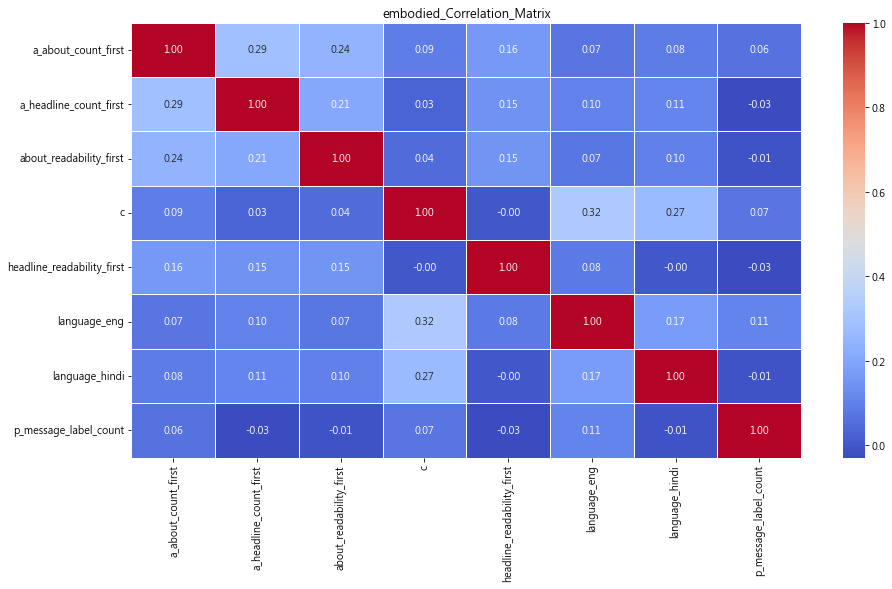

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# 定义自变量和因变量
X = embodied_df.drop(columns=["cluster","link"])  # 自变量
# X = embodied_df.drop(columns=["link"])  # 自变量
# y = embodied_df["cluster"]  # 因变量

# 计算相关系数矩阵
correlation_matrix = X.corr()

# 绘制相关系数矩阵图
plt.figure(figsize=(15, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
# plt.xticks(rotation=45)
plt.title("embodied_Correlation_Matrix")
plt.show()


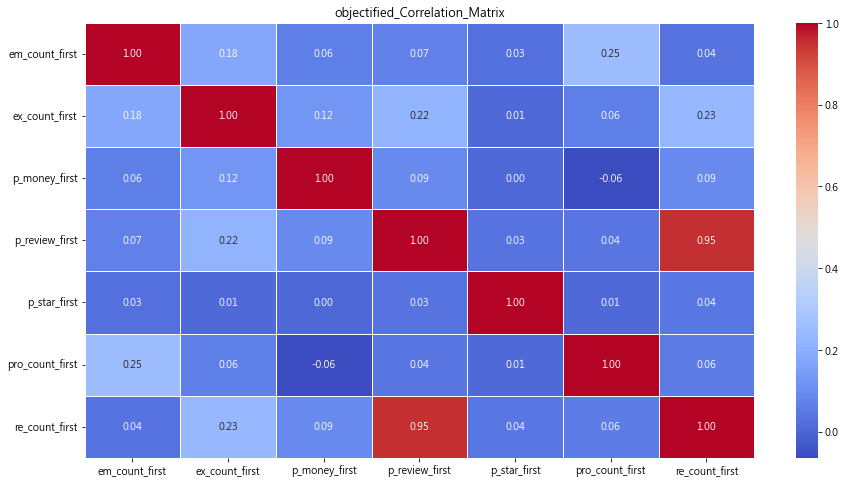

In [18]:

# 定义自变量和因变量
X = objectified_df.drop(columns=["cluster","link"])  # 自变量
y = objectified_df["cluster"]  # 因变量

# 计算相关系数矩阵
correlation_matrix = X.corr()

# 绘制相关系数矩阵图
plt.figure(figsize=(15, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
# plt.xticks(rotation=45)
plt.title("objectified_Correlation_Matrix")
plt.show()


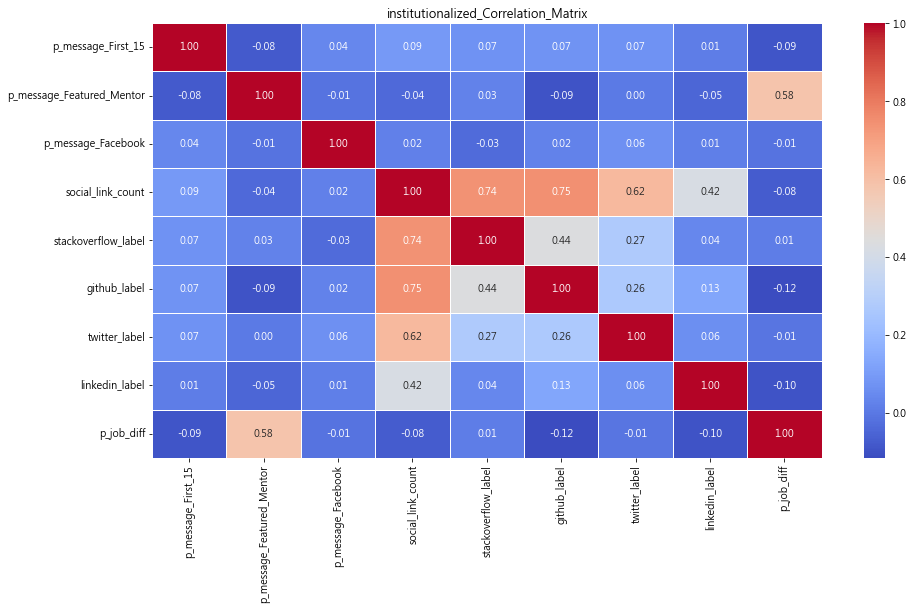

In [19]:

# 定义自变量和因变量
X = institutionalized_df.drop(columns=["cluster","link"])  # 自变量
y = institutionalized_df["cluster"]  # 因变量

# 计算相关系数矩阵
correlation_matrix = X.corr()

# 绘制相关系数矩阵图
plt.figure(figsize=(15, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
# plt.xticks(rotation=15)
plt.title("institutionalized_Correlation_Matrix")
plt.show()


<h1 align='center'>embodied 資本 PCA分析</h1>

In [113]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


# 提取特征列
# 提取特征列
# features = embodied_df.columns[1:]  # 假设第一列是链接，我们不使用链接进行PCA
features = embodied_df.columns.drop(['cluster','link'])
# 对数据进行标准化处理
scaler = StandardScaler()
embodied_scaled_data = scaler.fit_transform(embodied_df[features])

# 应用PCA
embodied_pca = PCA()
embodied_pca.fit(embodied_scaled_data)

# 获取每个主成分的解释方差比例
explained_variance_ratio = embodied_pca.explained_variance_ratio_.round(3)

# 创建DataFrame来存储主成分及其解释方差比例
embodied_pc_df = pd.DataFrame({'Principal Component': range(1, len(explained_variance_ratio) + 1),
                      'Explained Variance Ratio': explained_variance_ratio})

# 按照解释方差比例由高到低排序
embodied_pc_df = embodied_pc_df.sort_values(by='Explained Variance Ratio', ascending=False)

# 打印排名表格
embodied_pc_df

In [114]:
embodied_loadings = pd.DataFrame(embodied_pca.components_, columns=features)

# 打印主成分载荷矩阵
embodied_loadings

,a_about_count_first,a_headline_count_first,about_readability_first,c,headline_readability_first,language_eng,language_hindi,p_message_label_count
0,0.438668,0.416335,0.387679,0.363489,0.269716,0.386188,0.351194,0.081185
1,0.302430,0.323154,0.310931,-0.522036,0.336273,-0.404686,-0.323642,-0.230898
2,0.189472,-0.068613,-0.034338,-0.094382,0.102967,0.115121,-0.424917,0.863073
3,-0.274665,-0.203195,-0.171372,0.081216,0.770792,0.370076,-0.258439,-0.222350
4,-0.163861,-0.598276,0.750443,0.024888,0.084568,-0.139880,0.127305,0.092234
5,0.073213,-0.109790,-0.341129,-0.094612,0.436461,-0.458722,0.620916,0.266092
6,0.651961,-0.424794,-0.182023,0.438353,-0.006540,-0.230151,-0.252479,-0.229026
7,0.384060,-0.354687,-0.099063,-0.614919,-0.108440,0.503902,0.243073,-0.118300


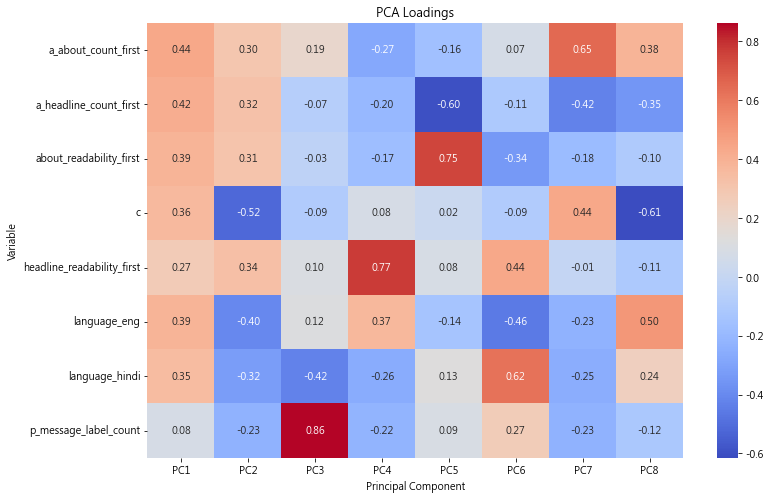

In [115]:
X = embodied_df.drop(columns=["cluster","link"])  # 自变量

# 对数据进行标准化处理
scaler = StandardScaler()
scaled_data = scaler.fit_transform(X)

# 应用PCA
pca = PCA()
pca.fit(scaled_data)

# 获取成分加载
loadings = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(pca.n_components_)], index=X.columns)

# 绘制成分加载的热力图
plt.figure(figsize=(12, 8))
sns.heatmap(loadings, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('PCA Loadings')
plt.xlabel('Principal Component')
plt.ylabel('Variable')
plt.show()

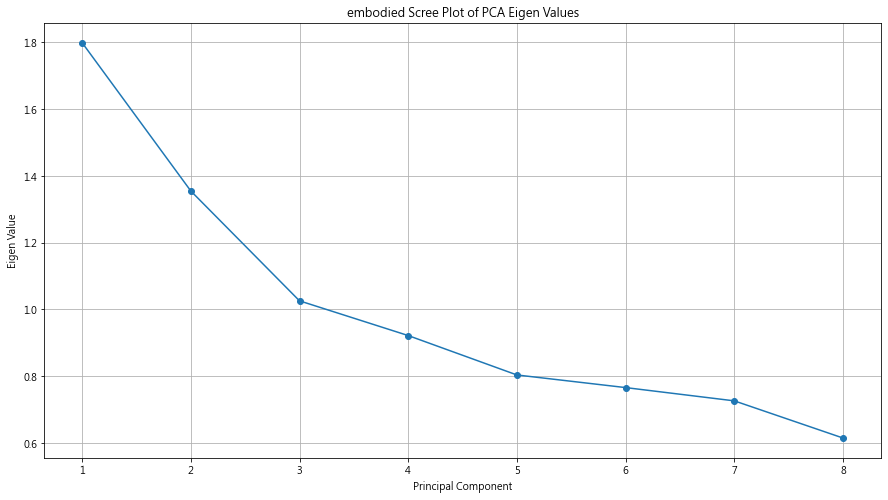

In [116]:
import numpy as np

# 提取PCA模型的explained variance
eigen_values = embodied_pca.explained_variance_

# 將eigen value繪製成圖表
plt.figure(figsize=(15, 8))
plt.plot(range(1, len(eigen_values) + 1), eigen_values, marker='o', linestyle='-')
plt.title('embodied Scree Plot of PCA Eigen Values')
plt.xlabel('Principal Component')
plt.ylabel('Eigen Value')
plt.grid(True)
plt.show()


In [117]:
eigen_values

array([1.79832317, 1.35432081, 1.02544081, 0.92149887, 0.80353057,
       0.7657475 , 0.72600922, 0.61473288])

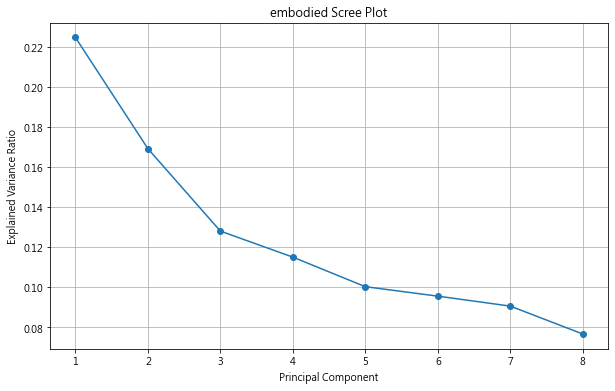

In [118]:
X = embodied_df.drop(columns=["cluster","link"])  # 自变量

# 对数据进行标准化处理
scaler = StandardScaler()
scaled_data = scaler.fit_transform(X)

# 应用PCA
pca = PCA()
pca.fit(scaled_data)

# 绘制 Scree plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, pca.n_components_ + 1), pca.explained_variance_ratio_, marker='o', linestyle='-')
plt.title('embodied Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.xticks(range(1, pca.n_components_ + 1))
plt.grid(True)
plt.show()

<h1 align='center'>objectified 資本 PCA分析</h1>

In [119]:
# features = objectified_df.columns[1:]  # 假设第一列是链接，我们不使用链接进行PCA
features = objectified_df.columns.drop(['cluster', 'link'])
# 对数据进行标准化处理
scaler = StandardScaler()
objectified_scaled_data = scaler.fit_transform(objectified_df[features])

# 应用PCA
objectified_pca = PCA()
objectified_pca.fit(objectified_scaled_data)

# 获取每个主成分的解释方差比例
objectified_explained_variance_ratio = objectified_pca.explained_variance_ratio_.round(3)

# 创建DataFrame来存储主成分及其解释方差比例
objectified_pc_df = pd.DataFrame({'Principal Component': range(1, len(objectified_explained_variance_ratio) + 1),
                      'Explained Variance Ratio': objectified_explained_variance_ratio})

# 按照解释方差比例由高到低排序
objectified_pc_df = objectified_pc_df.sort_values(by='Explained Variance Ratio', ascending=False)

# 打印排名表格
objectified_pc_df

,Principal Component,Explained Variance Ratio
0,1,0.300
1,2,0.182
2,3,0.151
3,4,0.142
4,5,0.117
5,6,0.101
6,7,0.006


In [120]:
objectified_df.to_csv(r"C:\Users\Modern 14\Desktop\codementorAll\test\objectified_df.csv", index=False)

In [27]:
objectified_loadings = pd.DataFrame(objectified_pca.components_, columns=features)

# 打印主成分载荷矩阵
objectified_loadings

,em_count_first,ex_count_first,p_money_first,p_review_first,p_star_first,pro_count_first,re_count_first
0,0.143261,0.311133,0.145829,0.651231,0.050294,0.097104,0.652185
1,0.681958,0.273519,0.011002,-0.186906,0.050240,0.620896,-0.192433
2,0.093683,0.373718,0.809292,-0.156745,-0.088369,-0.371840,-0.161130
3,-0.002661,0.040762,-0.075439,0.034231,-0.991673,0.085399,0.027584
4,-0.051559,0.764851,-0.532327,-0.097432,0.037646,-0.331389,-0.090800
5,0.708415,-0.319116,-0.185973,0.095235,-0.047505,-0.590926,0.034761
6,0.033413,-0.015037,-0.003360,-0.704741,-0.006987,-0.022126,0.708129


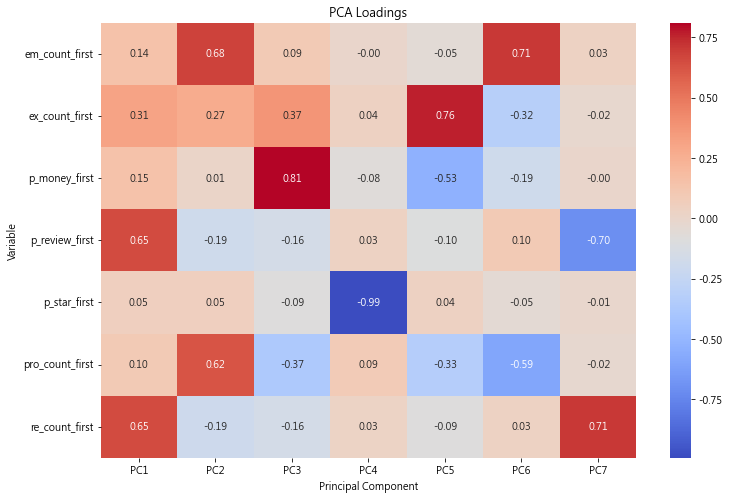

In [28]:
X = objectified_df.drop(columns=["cluster","link"])  # 自变量

# 对数据进行标准化处理
scaler = StandardScaler()
scaled_data = scaler.fit_transform(X)

# 应用PCA
objectified_pca = PCA()
objectified_pca.fit(scaled_data)

# 获取成分加载
loadings = pd.DataFrame(objectified_pca.components_.T, columns=[f'PC{i+1}' for i in range(objectified_pca.n_components_)], index=X.columns)

# 绘制成分加载的热力图
plt.figure(figsize=(12, 8))
sns.heatmap(loadings, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('PCA Loadings')
plt.xlabel('Principal Component')
plt.ylabel('Variable')
plt.show()

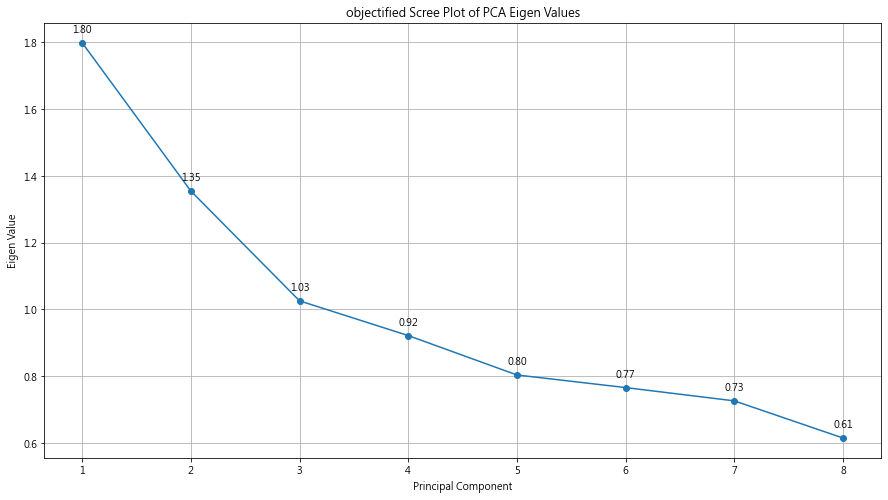

In [29]:
X = objectified_df.drop(columns=["cluster","link"])  # 自变量

# 对数据进行标准化处理
scaler = StandardScaler()
scaled_data = scaler.fit_transform(X)

# 应用PCA
objectified_pca = PCA()
objectified_pca.fit(scaled_data)

# 绘制 Scree plot
plt.figure(figsize=(15, 8))
plt.plot(range(1, len(eigen_values) + 1), eigen_values, marker='o', linestyle='-')
plt.title('objectified Scree Plot of PCA Eigen Values')
plt.xlabel('Principal Component')
plt.ylabel('Eigen Value')
plt.grid(True)

# 添加數值標籤
for i, (x, y) in enumerate(zip(range(1, len(eigen_values) + 1), eigen_values)):
    plt.annotate(f'{y:.2f}', (x, y), textcoords="offset points", xytext=(0,10), ha='center')

plt.show()


<h1 align='center'>institutional 資本 PCA分析</h1>

In [121]:
# features = institutionalized_df.columns[1:]  # 假设第一列是链接，我们不使用链接进行PCA
features = institutionalized_df.columns.drop(['cluster', 'link','p_job_diff'])
# 对数据进行标准化处理
scaler = StandardScaler()
scaled_data = scaler.fit_transform(institutionalized_df[features])

# 应用PCA
institutional_pca = PCA()
institutional_pca.fit(scaled_data)

# 获取每个主成分的解释方差比例
institutionalized_explained_variance_ratio = pca.explained_variance_ratio_.round(3)

# 创建DataFrame来存储主成分及其解释方差比例
institutionalized_pc_df = pd.DataFrame({'Principal Component': range(1, len(institutionalized_explained_variance_ratio) + 1),
                      'Explained Variance Ratio': institutionalized_explained_variance_ratio})

# 按照解释方差比例由高到低排序
institutionalized_pc_df = institutionalized_pc_df.sort_values(by='Explained Variance Ratio', ascending=False)

# 打印排名表格
institutionalized_pc_df

,Principal Component,Explained Variance Ratio
0,1,0.225
1,2,0.169
2,3,0.128
3,4,0.115
4,5,0.100
5,6,0.096
6,7,0.091
7,8,0.077


In [122]:
institutionalized_df.to_csv(r"C:\Users\Modern 14\Desktop\codementorAll\test\institutionalized_df.csv", index=False)

In [31]:
institutionalized_loadings = pd.DataFrame(institutional_pca.components_, columns=features)

# 打印主成分载荷矩阵
institutionalized_loadings

,p_message_First_15,p_message_Featured_Mentor,p_message_Facebook,social_link_count,stackoverflow_label,github_label,twitter_label,linkedin_label
0,-9.265572e-02,4.387589e-02,-2.454852e-02,-0.606730,-0.456527,-0.469305,-0.383207,-0.212732
1,5.473275e-01,-6.789743e-01,3.846072e-01,-0.041023,-0.214560,0.020901,-0.051709,0.201679
2,3.107725e-01,3.404665e-01,5.702578e-01,-0.060316,0.107518,-0.035087,0.275384,-0.608312
3,-3.988867e-01,2.612970e-01,6.454373e-01,0.061226,-0.218145,-0.097169,0.067670,0.539135
4,-6.578455e-01,-5.507977e-01,2.170932e-01,-0.016081,0.070299,0.181312,0.035565,-0.421180
5,5.266901e-02,1.424510e-01,2.352406e-01,-0.011464,0.334702,0.357216,-0.825704,-0.006946
6,2.495317e-02,1.708944e-01,-8.499328e-02,-0.022938,-0.668330,0.708616,0.043740,-0.108203
7,-2.319242e-16,3.140311e-18,-1.810699e-16,-0.788602,0.350382,0.325622,0.291717,0.253400


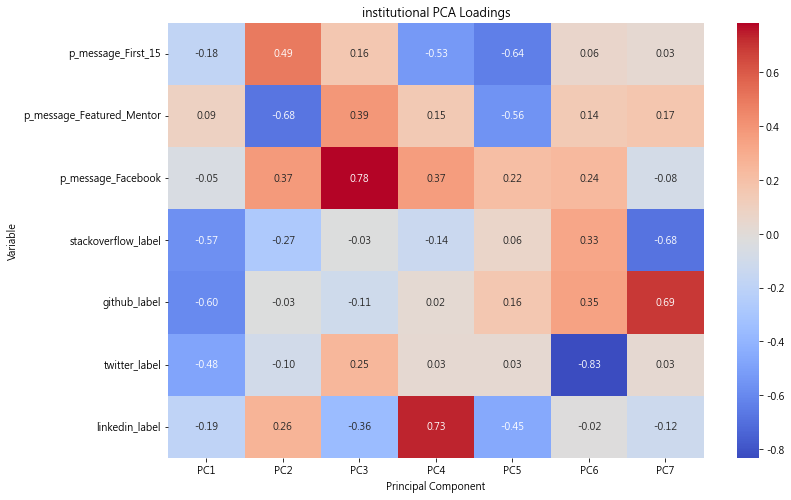

In [32]:
X = institutionalized_df.drop(columns=["cluster","link",'p_job_diff','social_link_count'])  # 自变量

# 对数据进行标准化处理
scaler = StandardScaler()
scaled_data = scaler.fit_transform(X)

# 应用PCA
institutional_pca = PCA()
institutional_pca.fit(scaled_data)

# 获取成分加载
loadings = pd.DataFrame(institutional_pca.components_.T, columns=[f'PC{i+1}' for i in range(institutional_pca.n_components_)], index=X.columns)

# 绘制成分加载的热力图
plt.figure(figsize=(12, 8))
sns.heatmap(loadings, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('institutional PCA Loadings')
plt.xlabel('Principal Component')
plt.ylabel('Variable')
plt.show()

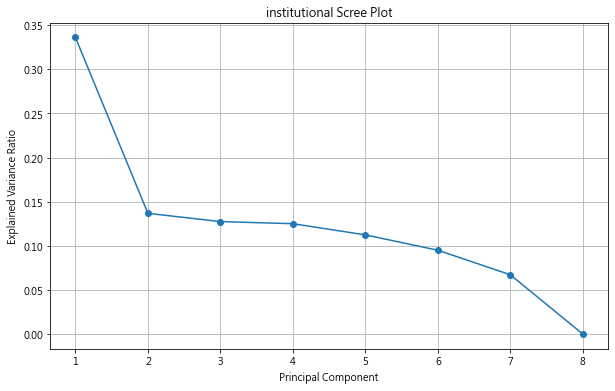

In [33]:
X = institutionalized_df.drop(columns=["cluster","link",'p_job_diff'])  # 自变量

# 对数据进行标准化处理
scaler = StandardScaler()
scaled_data = scaler.fit_transform(X)

# 应用PCA
institutional_pca = PCA()
institutional_pca.fit(scaled_data)

# 绘制 Scree plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, institutional_pca.n_components_ + 1), institutional_pca.explained_variance_ratio_, marker='o', linestyle='-')
plt.title('institutional Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.xticks(range(1, institutional_pca.n_components_ + 1))
plt.grid(True)
plt.show()

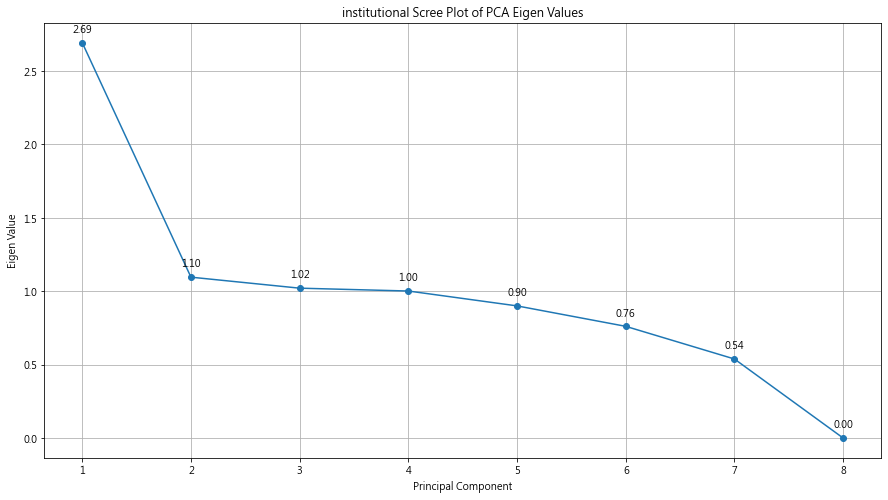

In [34]:
import numpy as np

# 提取PCA模型的explained variance
eigen_values = institutional_pca.explained_variance_

# 將eigen value繪製成圖表
plt.figure(figsize=(15, 8))
plt.plot(range(1, len(eigen_values) + 1), eigen_values, marker='o', linestyle='-')
plt.title('institutional Scree Plot of PCA Eigen Values')
plt.xlabel('Principal Component')
plt.ylabel('Eigen Value')
plt.grid(True)

# 添加數值標籤
for i, (x, y) in enumerate(zip(range(1, len(eigen_values) + 1), eigen_values)):
    plt.annotate(f'{y:.2f}', (x, y), textcoords="offset points", xytext=(0,10), ha='center')

plt.show()



<h1 align='center'>merged_data PCA分析</h1>

In [123]:
merged_df = pd.merge(institutionalized_df, objectified_df, on='link', how='inner')

# 再將 embodied_df 合併
merged_df = pd.merge(merged_df, embodied_df, on='link', how='inner')

In [124]:
# features = institutionalized_df.columns[1:]  # 假设第一列是链接，我们不使用链接进行PCA
features = merged_df.columns.drop(['cluster', 'link','p_job_diff','cluster_x','cluster_y'])
# 对数据进行标准化处理
scaler = StandardScaler()
scaled_data = scaler.fit_transform(merged_df[features])

# 应用PCA
merged_pca = PCA()
merged_pca.fit(scaled_data)

# 获取每个主成分的解释方差比例
merged_explained_variance_ratio = pca.explained_variance_ratio_.round(3)

# 创建DataFrame来存储主成分及其解释方差比例
merged_pc_df = pd.DataFrame({'Principal Component': range(1, len(merged_explained_variance_ratio) + 1),
                      'Explained Variance Ratio': merged_explained_variance_ratio})
# # 按照解释方差比例由高到低排序
merged_pc_df = merged_pc_df.sort_values(by='Explained Variance Ratio', ascending=False)

# 打印排名表格
merged_pc_df

,Principal Component,Explained Variance Ratio
0,1,0.225
1,2,0.169
2,3,0.128
3,4,0.115
4,5,0.100
5,6,0.096
6,7,0.091
7,8,0.077


In [125]:
merged_df.to_csv(r"C:\Users\Modern 14\Desktop\codementorAll\test\merged_df_0403.csv", index=False)

In [105]:
merged_loadings = pd.DataFrame(merged_pca.components_, columns=features)

# 打印主成分载荷矩阵
merged_loadings

,p_message_First_15,p_message_Featured_Mentor,p_message_Facebook,social_link_count,stackoverflow_label,github_label,twitter_label,linkedin_label,em_count_first,ex_count_first,...,pro_count_first,re_count_first,a_about_count_first,a_headline_count_first,about_readability_first,c,headline_readability_first,language_eng,language_hindi,p_message_label_count
0,9.622470e-02,7.140581e-02,2.826628e-02,0.471286,0.366273,0.345661,0.324683,0.142270,2.504168e-01,1.836539e-01,...,1.905669e-01,1.703364e-01,1.792580e-01,1.512792e-01,1.136652e-01,1.755954e-01,7.058686e-02,2.280953e-01,1.125836e-01,1.296635e-01
1,-4.885450e-02,3.647214e-01,-9.901336e-03,-0.250615,-0.128721,-0.238606,-0.109917,-0.168800,-4.518076e-02,2.351997e-01,...,-5.938096e-02,5.113427e-01,2.314989e-01,1.002483e-01,3.143066e-02,-5.546172e-02,7.726179e-02,4.980243e-02,-1.887853e-02,1.460089e-01
2,-5.845844e-01,-1.942836e-01,-7.982164e-02,-0.017990,-0.041117,-0.009649,-0.025541,0.042670,1.085272e-01,1.400275e-01,...,1.418424e-01,2.292552e-02,1.535130e-01,2.296934e-01,1.882209e-01,-4.127736e-02,1.728939e-01,-3.001904e-02,6.036249e-02,-6.268457e-01
3,2.845803e-01,-1.167286e-01,8.838722e-02,-0.213889,-0.200074,-0.194778,-0.073828,-0.053711,1.298465e-01,2.114306e-01,...,9.416053e-03,-2.828297e-01,2.729968e-01,3.332396e-01,3.678921e-01,1.754982e-01,2.851314e-01,1.321406e-01,1.822131e-01,2.032151e-01
4,1.380298e-01,-9.157423e-02,1.109529e-01,0.083553,0.033438,0.095646,-0.008042,0.100140,1.565265e-01,1.169303e-01,...,5.121002e-02,-1.429465e-02,8.218955e-02,1.139888e-01,8.508825e-02,-5.559159e-01,1.679437e-01,-4.263893e-01,-5.300997e-01,9.102527e-02
5,-2.990047e-02,-1.350459e-01,3.345916e-02,0.009077,0.181689,0.054200,0.195336,-0.517498,-2.223585e-01,-4.710985e-02,...,-3.417213e-01,-6.453227e-02,4.312731e-02,-2.607248e-02,-2.185416e-02,9.251834e-02,1.890327e-02,2.064434e-01,-2.141993e-01,-9.026268e-02
6,-1.213091e-01,-2.239546e-02,5.594998e-01,-0.002186,0.014750,0.061593,0.034080,-0.145579,-1.384845e-01,-8.471513e-02,...,1.655318e-01,7.321397e-02,7.380695e-02,-2.294685e-02,1.084157e-01,1.930051e-02,-2.313811e-01,-1.076650e-01,1.758498e-01,-8.784248e-02
7,-6.861672e-02,-1.925946e-02,5.945059e-01,0.005283,-0.269687,-0.094708,0.113699,0.380154,1.362319e-01,2.045550e-01,...,-2.291979e-01,4.116529e-03,-2.150347e-01,1.169826e-01,-3.520497e-01,1.006472e-01,-1.961361e-03,1.557381e-01,-6.320433e-02,-3.301732e-02
8,6.100383e-02,-1.593581e-01,1.976951e-01,-0.171221,-0.078401,-0.008729,-0.067209,-0.335858,3.869408e-01,-7.351128e-02,...,5.609761e-01,5.329735e-02,-1.911758e-01,-3.298200e-01,1.830076e-03,1.077260e-01,1.427440e-01,2.112470e-01,-2.338752e-01,-1.693109e-03
9,-1.123121e-01,3.315544e-01,3.133886e-01,0.027683,-0.019206,-0.064687,0.240610,-0.081161,-2.477688e-01,-9.371221e-02,...,1.827216e-01,-1.336952e-01,1.084717e-01,4.285837e-02,3.976973e-01,-1.271244e-01,-2.865376e-01,-6.764546e-02,-7.012446e-02,8.780543e-02


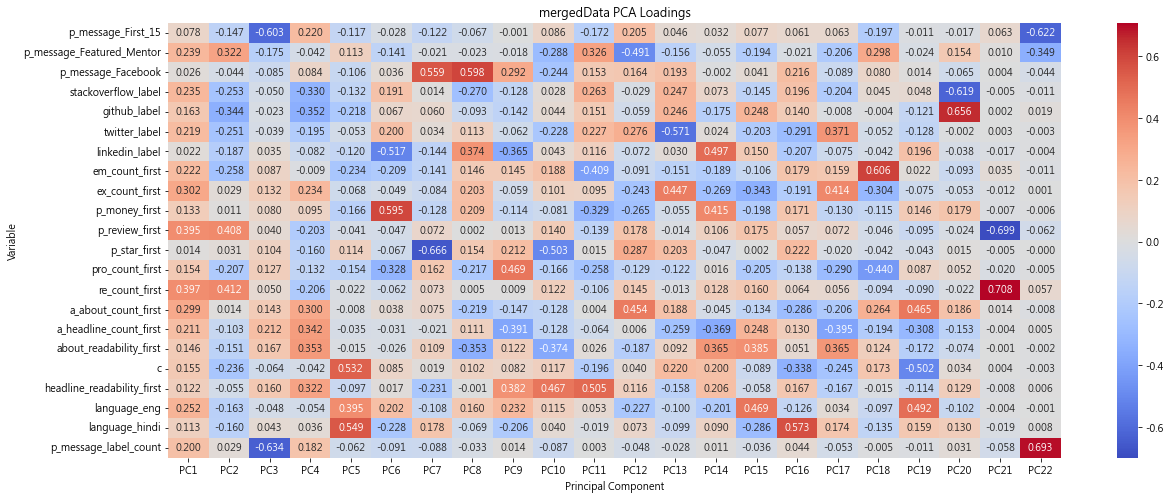

In [76]:
X = merged_df.drop(columns=["cluster","link",'p_job_diff','social_link_count','cluster_x','cluster_y'])  # 自变量

# 对数据进行标准化处理
scaler = StandardScaler()
scaled_data = scaler.fit_transform(X)

# 应用PCA
merged_pca = PCA()
merged_pca.fit(scaled_data)

# 获取成分加载
loadings = pd.DataFrame(merged_pca.components_.T, columns=[f'PC{i+1}' for i in range(merged_pca.n_components_)], index=X.columns)

# 绘制成分加载的热力图
plt.figure(figsize=(20, 8))
sns.heatmap(loadings, cmap='coolwarm', annot=True, fmt=".3f")
plt.title('mergedData PCA Loadings')
plt.xlabel('Principal Component')
plt.ylabel('Variable')
plt.show()

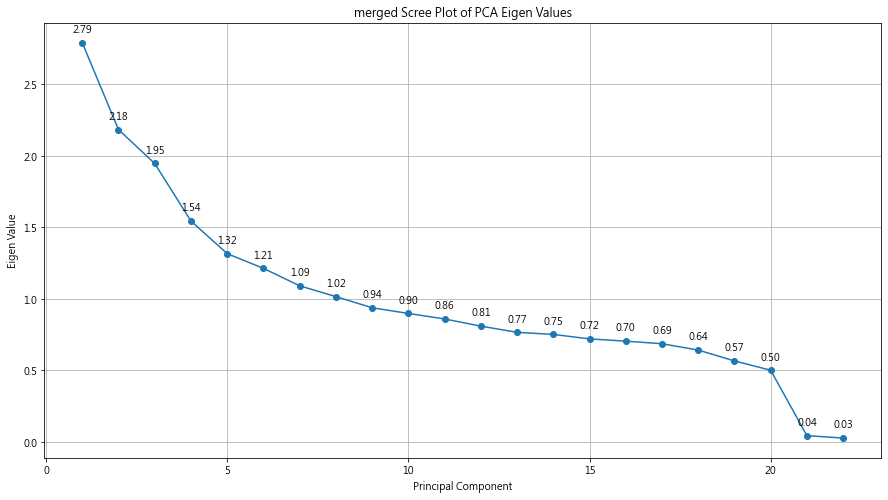

In [78]:
import numpy as np

# 提取PCA模型的explained variance
eigen_values = merged_pca.explained_variance_

# 將eigen value繪製成圖表
plt.figure(figsize=(15, 8))
plt.plot(range(1, len(eigen_values) + 1), eigen_values, marker='o', linestyle='-')
plt.title('merged Scree Plot of PCA Eigen Values')
plt.xlabel('Principal Component')
plt.ylabel('Eigen Value')
plt.grid(True)

# 添加數值標籤
for i, (x, y) in enumerate(zip(range(1, len(eigen_values) + 1), eigen_values)):
    plt.annotate(f'{y:.2f}', (x, y), textcoords="offset points", xytext=(0,10), ha='center')

plt.show()



<h1 align='center'>discrimnant analysis</h1>

In [79]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
# np.set_printoptions(suppress=True, precision=3)

merged_pca_df 區別分析

In [176]:
merged_pca_df = pd.read_csv(r"C:\Users\Modern 14\Desktop\codementorAll\test\Merge_Sep_02.csv")

In [177]:

# 定義自變量和因變量
X = merged_pca_df.drop(columns=['link', 'cluster'])  # 自變量
y = merged_pca_df['cluster']  # 因變量
features = X.columns
LDA=LinearDiscriminantAnalysis(n_components=3)
lda_x=LDA.fit_transform(X,y)

LDA.explained_variance_ratio_
np.cumsum(LDA.explained_variance_ratio_)

array([0.9130656 , 0.96984552, 1.        ])

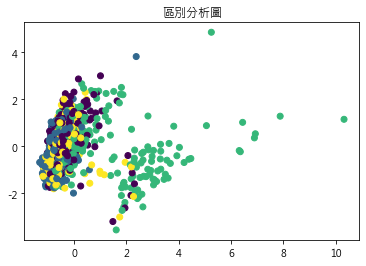

In [158]:
plt.title('區別分析圖')
plt.scatter(lda_x[:,0], lda_x[:,1], c = y)

explained variance ratio (first two components): [0.63322959 0.31122016 0.01360598]


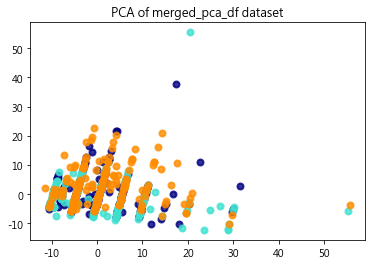

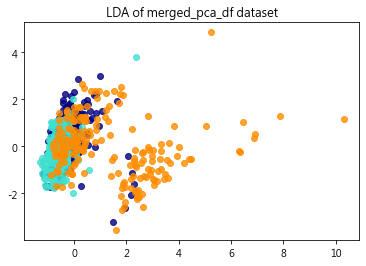

In [195]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


X = merged_pca_df.drop(columns=['link', 'cluster'])  # 自變量
y = merged_pca_df['cluster']  # 因變量
target_names = merged_pca_df.columns

pca = PCA(n_components=3)
X_r = pca.fit(X).transform(X)

lda = LinearDiscriminantAnalysis(n_components=3)
X_r2 = lda.fit(X, y).transform(X)

# Percentage of variance explained for each components
print(
    "explained variance ratio (first two components): %s"
    % str(pca.explained_variance_ratio_)
)

plt.figure()
colors = ["navy", "turquoise", "darkorange"]
lw = 2

for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(
        X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=0.8, lw=lw, label=target_name
    )
# plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("PCA of merged_pca_df dataset")

plt.figure()
for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(
        X_r2[y == i, 0], X_r2[y == i, 1], alpha=0.8, color=color, label=target_name
    )
# plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("LDA of merged_pca_df dataset")

plt.show()

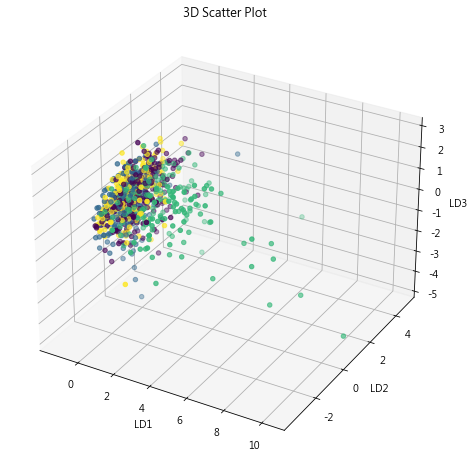

In [187]:
from mpl_toolkits.mplot3d import Axes3D

# 创建一个大尺寸的三维图形对象
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# 绘制三维散点图
ax.scatter(lda_x[:, 0], lda_x[:, 1], lda_x[:, 2], c=y, cmap='viridis')

# 设置图形标题和轴标签
ax.set_title('3D Scatter Plot')
ax.set_xlabel('LD1')
ax.set_ylabel('LD2')
ax.set_zlabel('LD3')

# 显示图形
plt.show()


In [ ]:
# 提取LDA模型的主成分係數
components = LDA.coef_

# 創建包含係數的DataFrame

merged_component_df = pd.DataFrame(components, columns=features, index=[f'LD{i+1}' for i in range(components.shape[0])])

# 印出主成分係數
merged_component_df



,Language2,Introduction2,Label2,Review2,EM_PROJ2,Expertise2,Money2,Internal2,Extenal2
LD1,-0.062977,0.020858,-0.566300,-0.079952,0.076900,0.000866,0.003207,-0.246826,0.145561
LD2,-0.159963,0.057342,-0.150397,-0.334558,-0.156035,-0.037987,0.000582,-0.470150,0.041020
LD3,0.193105,-0.006007,1.198968,0.784448,0.113327,0.055024,0.015139,1.039513,-0.176184
LD4,0.065947,-0.087290,-0.316174,-0.328960,-0.043818,-0.015228,-0.020784,-0.215447,-0.059164


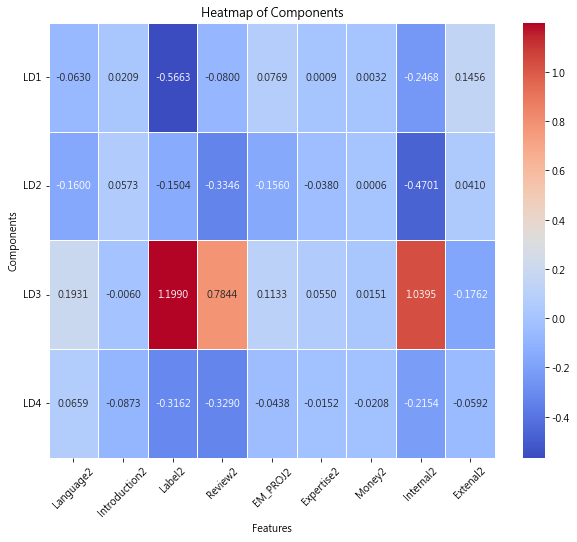

In [ ]:
# 创建热力图
plt.figure(figsize=(10, 8))
sns.heatmap(merged_component_df, cmap='coolwarm', annot=True, fmt=".4f", linewidths=0.5)
plt.title('Heatmap of Components')
plt.xlabel('Features')
plt.ylabel('Components')
plt.xticks(rotation=45)  # 旋转 x 轴标签以便于阅读
plt.yticks(rotation=0)   # 旋转 y 轴标签以便于阅读
plt.show()


In [ ]:
# 創建係數和變數名稱的對應表
coef_df_1 = pd.DataFrame({'Feature': features, 'Coefficient_1': LDA.coef_[0]})
coef_df_2 = pd.DataFrame({'Feature': features, 'Coefficient_2': LDA.coef_[1]})
coef_df_3 = pd.DataFrame({'Feature': features, 'Coefficient_3': LDA.coef_[2]})
coef_df_4 = pd.DataFrame({'Feature': features, 'Coefficient_4': LDA.coef_[3]})

# 合併所有係數和變數名稱的對應表
all_coef_df = pd.merge(coef_df_1, coef_df_2, on='Feature')
all_coef_df = pd.merge(all_coef_df, coef_df_3, on='Feature')
all_coef_df = pd.merge(all_coef_df, coef_df_4, on='Feature')

# 印出係數和變數名稱對應表
all_coef_df.round(3)


,Feature,Coefficient_1,Coefficient_2,Coefficient_3,Coefficient_4
0,Language2,-0.063,-0.160,0.193,0.066
1,Introduction2,0.021,0.057,-0.006,-0.087
2,Label2,-0.566,-0.150,1.199,-0.316
3,Review2,-0.080,-0.335,0.784,-0.329
4,EM_PROJ2,0.077,-0.156,0.113,-0.044
5,Expertise2,0.001,-0.038,0.055,-0.015
6,Money2,0.003,0.001,0.015,-0.021
7,Internal2,-0.247,-0.470,1.040,-0.215
8,Extenal2,0.146,0.041,-0.176,-0.059


In [ ]:
# import pandas as pd
# import numpy as np
# import statsmodels.api as sm


# # 定义自变量和因变量
# X = merged_df.drop(columns=["p_job_diff","link","cluster_x",'cluster_y'])  # 自变量
# y = merged_df["cluster"]  # 因变量

# # 前向逐步选择
# def forward_stepwise_selection(X, y):
#     initial_features = X.columns.tolist()
#     best_features = []
#     all_features = []
#     while (len(initial_features)>0):
#         remaining_features = list(set(initial_features)-set(best_features))
#         new_pval = pd.Series(index=remaining_features)
#         for new_column in remaining_features:
#             model = sm.OLS(y, sm.add_constant(X[best_features+[new_column]])).fit()
#             new_pval[new_column] = model.pvalues[new_column]
#         min_p_value = new_pval.min()
#         if(min_p_value<0.05):
#             best_feature = new_pval.idxmin()
#             best_features.append(best_feature)
#             all_features.append(best_features.copy())
#         else:
#             break
#     return all_features

# selected_features_history = forward_stepwise_selection(X, y)
# for i, features in enumerate(selected_features_history):
#     print(f"Step {i+1}: {features}")

In [ ]:
# import statsmodels.api as sm


# # 定义自变量和因变量
# X = institutionalized_df.drop(columns=["p_job_diff","link","cluster"])  # 自变量
# y = institutionalized_df["cluster"]  # 因变量

# # 后向逐步选择
# def backward_stepwise_selection(X, y):
#     features = X.columns.tolist()
#     while (len(features) > 0):
#         X_subset = X[features]
#         model = sm.OLS(y, sm.add_constant(X_subset)).fit()
#         p_values = model.pvalues.drop('const')
#         max_p_value = p_values.max()
#         if max_p_value > 0.05:
#             remove_feature = p_values.idxmax()
#             features.remove(remove_feature)
#         else:
#             break
#     return features

# selected_features = backward_stepwise_selection(X, y)
# print("Selected features:", selected_features)


<h1>stepwise Selection</h1>

In [ ]:
# import pandas as pd
# import numpy as np
# import statsmodels.api as sm


# # 定义自变量和因变量
# X = diff_df.drop(columns=["p_job_diff","link","cluster"])  # 自变量
# y = diff_df["cluster"]  # 因变量

# # 前向逐步选择
# def forward_stepwise_selection(X, y):
#     initial_features = X.columns.tolist()
#     best_features = []
#     all_features = []
#     while (len(initial_features)>0):
#         remaining_features = list(set(initial_features)-set(best_features))
#         new_pval = pd.Series(index=remaining_features)
#         for new_column in remaining_features:
#             model = sm.OLS(y, sm.add_constant(X[best_features+[new_column]])).fit()
#             new_pval[new_column] = model.pvalues[new_column]
#         min_p_value = new_pval.min()
#         if(min_p_value<0.05):
#             best_feature = new_pval.idxmin()
#             best_features.append(best_feature)
#             all_features.append(best_features.copy())
#         else:
#             break
#     return all_features

# selected_features_history = forward_stepwise_selection(X, y)
# for i, features in enumerate(selected_features_history):
#     print(f"Step {i+1}: {features}")

In [ ]:
# import pandas as pd
# import numpy as np
# import statsmodels.api as sm

# # 加载数据到 DataFrame


# # 定义自变量和因变量
# X = diff_df.drop(columns=["p_job_diff","link"])  # 自变量
# y = diff_df["p_job_diff"]  # 因变量

# # 前向逐步选择
# def forward_stepwise_selection(X, y):
#     initial_features = X.columns.tolist()
#     best_features = []
#     while (len(initial_features) > 0):
#         remaining_features = list(set(initial_features) - set(best_features))
#         new_pval = pd.Series(index=remaining_features)
#         for new_column in remaining_features:
#             model = sm.OLS(y, sm.add_constant(X[best_features+[new_column]])).fit()
#             new_pval[new_column] = model.pvalues[new_column]
#         min_p_value = new_pval.min()
#         if(min_p_value < 0.05):
#             best_feature = new_pval.idxmin()
#             best_features.append(best_feature)
#             # 输出当前步骤的模型系数
#             print("Step:", len(best_features))
#             print(model.params)
#         else:
#             break
#     return best_features

# selected_features = forward_stepwise_selection(X, y)

In [ ]:
# import pandas as pd
# from statsmodels.stats.outliers_influence import variance_inflation_factor

# diff_df

# # 定义自变量（不包括目标变量）
# X = diff_df.drop(columns=["p_job_diff","link"])  

# # 计算 VIF
# vif_data = pd.DataFrame()
# vif_data["Feature"] = X.columns
# vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# # 打印结果
# vif_data